    ** This notebook consist of my work on "HackerEarth" Assignment. I would be using Transformer driven Architecture to classify different classes. 

# Problem Statement

![alt text](problem_statement_.JPG "Title")

![alt text](data_description.JPG "Title")

# Load Libraries 

In [1]:
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.cm as cm
from sklearn import metrics
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)
warnings.filterwarnings('ignore')

# Load Pre-Processed Data 

    ** Input Data is the preprocessed Data used will building ML Driven Model.

In [2]:
train_pre_processed=pd.read_pickle(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_train_pre_processed.pkl"
)
test_pre_processed=pd.read_pickle(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_test_pre_processed.pkl"
)

In [3]:
train_pre_processed['space'] = ' '
train_pre_processed['dump'] = train_pre_processed['reflection_period'] + train_pre_processed['space'] + \
    train_pre_processed['num_sentence'].apply(str) + \
    train_pre_processed['space'] + \
    train_pre_processed['pre_processed_clean_hm']
test_pre_processed['space'] = ' '
test_pre_processed['dump'] = test_pre_processed['reflection_period'] + test_pre_processed['space'] + \
    test_pre_processed['num_sentence'].apply(str) + \
    test_pre_processed['space'] + \
    test_pre_processed['pre_processed_clean_hm']

In [4]:
print(train_pre_processed.shape)
display(train_pre_processed.head())
print(test_pre_processed.shape)
display(test_pre_processed.head())

(60321, 9)


,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category,pre_processed_clean_hm,target,space,dump
0,27673,24h,I went on a successful date with someone I felt sympathy and connection with.,1,affection,go successful date someone felt sympathy connection,1,,24h 1 go successful date someone felt sympathy connection
1,27674,24h,I was happy when my son got 90% marks in his examination,1,affection,happy son get 90 mark examination,1,,24h 1 happy son get 90 mark examination
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise,go gym morning yoga,7,,24h 1 go gym morning yoga
3,27676,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,2,bonding,serious talk friends flaky lately understood good evening hanging,3,,24h 2 serious talk friends flaky lately understood good evening hanging
4,27677,24h,I went with grandchildren to butterfly display at Crohn Conservatory\r\r\n,1,affection,go grandchild butterfly display crohn conservatory,1,,24h 1 go grandchild butterfly display crohn conservatory


(40213, 7)


,hmid,reflection_period,cleaned_hm,num_sentence,pre_processed_clean_hm,space,dump
0,88305,3m,I spent the weekend in Chicago with my friends.,1,spent weekend chicago friend,,3m 1 spent weekend chicago friend
1,88306,3m,We moved back into our house after a remodel. We had lived in a hotel for 9 months due to our home being severely damaged in a tornado.,2,move back house remodel live hotel 9 month due home severely damage tornado,,3m 2 move back house remodel live hotel 9 month due home severely damage tornado
2,88307,3m,My fiance proposed to me in front of my family in the beginning of March.,1,fiance propose front family begin march,,3m 1 fiance propose front family begin march
3,88308,3m,I ate lobster at a fancy restaurant with some friends.,1,ate lobster fancy restaurant friend,,3m 1 ate lobster fancy restaurant friend
4,88309,3m,"I went out to a nice restaurant on a date with my wife. It was a very popular restaurant and we could not get a reservation. But I have a friend who owns a famous hamburger place next door to this restaurant. He was able to get us a table! We had a great table, great service, great food, and they even comped most of our dinner, so we paid almost nothing!",5,go nice restaurant date wife popular restaurant could get reservation friend own famous hamburger place next door restaurant able get You table great table great service great food even comped dinner pay almost nothing,,3m 5 go nice restaurant date wife popular restaurant could get reservation friend own famous hamburger place next door restaurant able get You table great table great service great food even comped dinner pay almost nothing


## Target Mapping

In [5]:
target_mapping = {
    'affection': 0,
    'achievement': 1,
    'bonding': 2,
    'enjoy_the_moment': 3,
    'leisure': 4,
    'nature': 5,
    'exercise': 6
}

In [6]:
train_pre_processed['target'] = train_pre_processed.predicted_category.apply(
    lambda x: target_mapping[x]).copy()

# Define Architecture Transformer 

In [7]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [8]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Hyper-Space

In [13]:
vocab_size = 60000
maxlen = 350
embed_dim = 32 
num_heads = 4 
ff_dim = 32  

# Data Ready For Deep-Learning

In [14]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_pre_processed.dump)
X_train = tokenizer.texts_to_sequences(train_pre_processed.dump)
X_test = tokenizer.texts_to_sequences(test_pre_processed.dump)
train = keras.preprocessing.sequence.pad_sequences(np.array(X_train),
                                                   maxlen=maxlen)
test = keras.preprocessing.sequence.pad_sequences(np.array(X_test),
                                                  maxlen=maxlen)
del X_train, X_test

In [15]:
print(train.shape)
print(test.shape)

(60321, 350)
(40213, 350)


In [16]:
Y_train = keras.utils.to_categorical(
    pd.Series(np.array(train_pre_processed.target), dtype=float), 7)

# Model Architecture

In [80]:
inputs = layers.Input(shape=(maxlen, ))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(20, activation="relu")(x)

outputs = layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [81]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 350)]             0         
_________________________________________________________________
token_and_position_embedding (None, 350, 32)           1931200   
_________________________________________________________________
transformer_block_7 (Transfo (None, 350, 32)           19040     
_________________________________________________________________
global_average_pooling1d_7 ( (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                1650      
_________________________________________________________________
dropout_33 (Dropout)         (None, 50)                0   

In [82]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=[keras.metrics.categorical_accuracy])

In [83]:
history = model.fit(train,
                    Y_train,
                    batch_size=32,
                    epochs=5,
                    validation_split=0.1,
                    callbacks=tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=5,
                        verbose=1,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    ),
                    use_multiprocessing=True)

Epoch 1/5
1697/1697 [==============================] - 38s 22ms/step - loss: 1.5428 - categorical_accuracy: 0.3553 - val_loss: 1.0369 - val_categorical_accuracy: 0.5425
Epoch 2/5
1697/1697 [==============================] - 37s 22ms/step - loss: 0.8866 - categorical_accuracy: 0.6615 - val_loss: 0.5517 - val_categorical_accuracy: 0.8202
Epoch 3/5
1697/1697 [==============================] - 37s 22ms/step - loss: 0.5122 - categorical_accuracy: 0.8363 - val_loss: 0.4606 - val_categorical_accuracy: 0.8510
Epoch 4/5
1697/1697 [==============================] - 37s 22ms/step - loss: 0.4104 - categorical_accuracy: 0.8687 - val_loss: 0.4690 - val_categorical_accuracy: 0.8463
Epoch 5/5
1697/1697 [==============================] - 37s 22ms/step - loss: 0.3618 - categorical_accuracy: 0.8868 - val_loss: 0.4596 - val_categorical_accuracy: 0.8570


# Model Evaluate 

## Learning Curve 

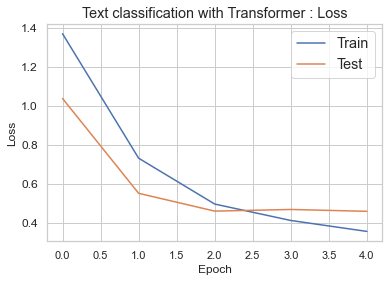

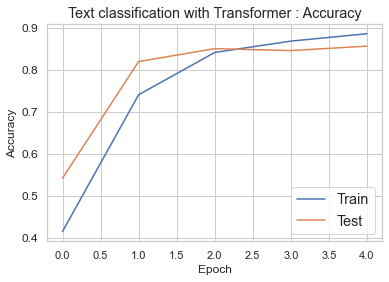

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Text classification with Transformer : Loss', fontsize='x-large')
plt.ylabel('Loss', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], loc='upper right', fontsize='x-large')
plt.rc('ytick', labelsize=12)
plt.show()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Text classification with Transformer : Accuracy',
          fontsize='x-large')
plt.ylabel('Accuracy', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['Train', 'Test'], fontsize='x-large', loc='lower right')
plt.show()

## Train Evaluate 

In [85]:
print(
    metrics.classification_report(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(model.predict(train, workers=-1, use_multiprocessing=True),
                  axis=1).tolist()))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     20880
           1       0.95      0.89      0.92     20274
           2       0.91      0.96      0.93      6561
           3       0.84      0.81      0.83      6508
           4       0.87      0.86      0.87      4242
           5       0.79      0.82      0.81      1127
           6       0.79      0.84      0.81       729

    accuracy                           0.91     60321
   macro avg       0.87      0.88      0.87     60321
weighted avg       0.91      0.91      0.91     60321



# Final Submission

In [86]:
def get_key(val):
    for key, value in target_mapping.items():
        if val == value:
            return key

    return "key doesn't exist"

In [116]:
test_pre_processed['pred'] = np.argmax(model.predict(test,
                                                     workers=-1,
                                                     use_multiprocessing=True),
                                       axis=1)
test_pre_processed['predicted_category'] = test_pre_processed['pred'].apply(
    lambda x: get_key(x))
test_pre_processed[['hmid', 'predicted_category']].to_csv(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\Submission\\submission_13_transformer.csv",
    index=False)

# End 